# Laurel Code

# Learning on `low_1.mp4` taken on July 20th, 2023
We run through the two-step process of learning a reduced order model for plume dynamics.
1. Applying plume_learner to video data to acquire a time series of polynomial coefficients learned ($X$). For both mean plume path and paths of edges of plume. $$X_{\text{mean}} = \begin{bmatrix} a_0 & b_0 & c_0\\ a_1 & b_1 & c_1\\ & \vdots & \\ a_n & b_n & c_n\end{bmatrix} $$ where $a(t)x^2 + b(t)x + c(t)$ are the learned polynomials for the mean path of plume.

2. Applying Model Discovery method to learned time series $X$. Primarily working with Ensemble SINDy methods.

## Import PLUME object from models.py

In [1]:
import sys
sys.path.append('/home/ldoyle/malachite_ara')
from models import PLUME

## Instantiate PLUME object

Videos can be found on Doppio in `home/ara/data/plume_videos` directory

We will work with the low velocity video `low_2.MP4` taken on July 20th, 2023.

In [2]:
# specify path to video (Example videos can be found on Doppio)
video_path = "/home/ldoyle/malachite_ara/plume_videos/July_20/video_low_1/low_1.MP4"
plume_learner = PLUME(video_path=video_path)

### Declare $(x,y)$ leak source of plume
helper functions `VideoPointPicker` & `ImagePointPicker` from `utils.py` can be used to find original leak source. 

Example code can be found in `test_functions/get_center.py`

In [3]:
plume_leak_source = (1588, 1017)
plume_learner.orig_center = plume_leak_source

### Declare `fixed_range` for background subtraction and `img_range` to apply concentric circle method

In [4]:
# Seconds until plume start
seconds = 4

# Frames until plume starts (used to create background image to apply fixed subtraction method)
fps= plume_learner.fps
fixed_range = seconds*fps

# Image range to apply concentric circle method 
img_range=[960,1320]

## Apply Concentric Circle method
*can take a little while to run*

In [5]:
save_path = "gauss_blur_coeff"

gauss_space_blur = True
gauss_kernel_size = 251
gauss_space_sigma = 105

gauss_time_blur = True
gauss_time_window = 5
gauss_time_sigma =0.5


mean_smoothing = True
mean_smoothing_sigma = 3

# plume_learner.train(img_range=img_range,
#                     fixed_range=fixed_range,
#                     gauss_space_blur=gauss_space_blur,
#                     gauss_kernel_size=gauss_kernel_size,
#                     gauss_space_sigma=gauss_space_sigma,
#                     gauss_time_blur=gauss_time_blur,
#                     gauss_time_window=gauss_time_window,
#                     gauss_time_sigma=gauss_time_sigma,
#                     mean_smoothing=mean_smoothing,
#                     mean_smoothing_sigma=mean_smoothing_sigma,
#                     save_path=save_path)

# Save arrays to pickle File

In [6]:
import pickle

### Save poly coeff from plume_learner

In [7]:
# arrays_dict = {}
# arrays_dict["mean"] = plume_learner.mean_poly
# arrays_dict["var1"] = plume_learner.var1_poly
# arrays_dict["var2"] = plume_learner.var2_poly

# pickle_name ="gauss_blur_coeff.pkl"

# with open(pickle_name, 'wb') as f:
#     pickle.dump(arrays_dict,f)

### Load poly coeff from pickle file

In [8]:
pickle_path = "/home/ldoyle/malachite_ara/plume_videos/July_20/video_low_1/gauss_blur_coeff.pkl"

with open(pickle_path, 'rb') as f:
    loaded_arrays = pickle.load(f)

mean_array = loaded_arrays["mean"]
var1_array = loaded_arrays["var1"]
var2_array = loaded_arrays["var2"]

# Apply ensemble SINDy

In [9]:
import pysindy as ps 
from sklearn.preprocessing import StandardScaler
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from utils import get_func_from_SINDy
from scipy.integrate import solve_ivp

# Set seed for replication of ensembling method

In [10]:
def sindy_pipeline(time_series,
                   window_length,
                   ensem_thresh,
                   ensem_alpha,
                   ensem_max_iter,
                   normalize=True,
                   poly_degree =2,
                   ensem_num_models = 20,
                #    stabalzing_eps = 1e-5,
                   ensem_time_points = 100):
    
    ##############################
    ## Apply normalized scaling ##
    ##############################

    t = np.array([i for i in range(len(time_series))])
    if normalize==True:
        print("normalize:", normalize)
        scalar = StandardScaler()
        time_series = scalar.fit_transform(time_series)

    ##########################
    ## Apply Ensemble SINDy ##
    ##########################
    feature_names = ['a', 'b', 'c']
    
    smoothed_fd = ps.SmoothedFiniteDifference(smoother_kws={'window_length': window_length})
    base_optimizer = ps.STLSQ(threshold=ensem_thresh, alpha=ensem_alpha, max_iter=ensem_max_iter)

    ensemble_optimizer=ps.optimizers.base.EnsembleOptimizer(base_optimizer, bagging=True, n_subset =ensem_time_points, n_models=ensem_num_models)

    poly_lib = ps.PolynomialLibrary(degree=poly_degree)
    model = ps.SINDy(feature_names=feature_names,
                     optimizer=ensemble_optimizer,
                     differentiation_method=smoothed_fd,
                     feature_library=poly_lib)
    # print(time_series)
    model.fit(time_series, t=t, ensemble=True, quiet=True)

    # print("window_length: {}, thresh: {}, alpha: {}, max iter: {}, stabalzing eps: {}".format(window_length, ensem_thresh, ensem_alpha, ensem_max_iter, stabalzing_eps))
    print("window_length: {}, thresh: {}, alpha: {}, max iter: {}".format(window_length, ensem_thresh, ensem_alpha, ensem_max_iter))
    model.print()

    #########################################
    ## Solve ODE system w/ Stabalzing Term ##
    #########################################
    # Get function in correct format to be evaluated 
    funcs = get_func_from_SINDy(model=model)

    # Define Right-hand side of ODE system 
    a_dot = lambda a,b,c: eval(funcs[0])
    b_dot = lambda a,b,c: eval(funcs[1])
    c_dot = lambda a,b,c: eval(funcs[2])

    # Get degree of feature library
    # poly_degree = model.feature_library.get_params()['degree']
    # stabalizing_degree = poly_degree+1

    # Define new ODE system 
    # def ode_sys(t, y,
    #             a_dot=a_dot,
    #             b_dot=b_dot,
    #             c_dot=c_dot, 
    #             stabalizing_deg=stabalizing_degree,
    #             eps = 1e-5):
    #     a,b,c = y
    #     da = a_dot(a,b,c) - eps*a**stabalizing_deg
    #     db = b_dot(a,b,c) - eps*b**stabalizing_deg
    #     dc = c_dot(a,b,c) - eps*c**stabalizing_deg
    #     rhs = [da,db,dc]
    #     return rhs

    # Initialize integrator keywords for solve_ivp to replicate the odeint defaults
    # integrator_keywords = {}
    # integrator_keywords["rtol"] = 1e-12
    # integrator_keywords["method"] = "LSODA"
    # integrator_keywords["atol"] = 1e-12

    t_solve = t

    y0 = time_series[0]

    # params = (a_dot,b_dot,c_dot,stabalizing_degree,stabalzing_eps)

    # print(f"Solving with eps = {stabalzing_eps}...")
    # X_solved = solve_ivp(ode_sys,
    #                     t_span=(t_solve[0],t_solve[-1]),
    #                     y0=y0, 
    #                     t_eval=t_solve,
    #                     args=params,
    #                     **integrator_keywords)
    
    ##################
    ## Plot Results ##
    ##################
    
    # X_stable_sim = X_solved.y

    # m = min(time_series.shape[0],X_stable_sim[0].shape[0])

    # fig, axs = plt.subplots(1,time_series.shape[1], sharex=True, figsize=(15, 4))
    # # fig.suptitle("Learned Normalized Coefficients")  # Add this line to set the title

    # for i in range(time_series.shape[1]):
    #     if i == time_series.shape[1]-1:
    #         axs[i].plot(t_solve[:m], time_series[:m, i], "k", label="true normalized data")
    #         axs[i].plot(t_solve[:m], X_stable_sim.T[:m, i], "r--", label="model simulation")
    #         axs[i].legend(loc="best")
    #     else:
    #         axs[i].plot(t_solve[:m], time_series[:m, i], "k")
    #         axs[i].plot(t_solve[:m], X_stable_sim.T[:m, i], "r--")
    #     axs[i].set(xlabel="t")
    #     axs[i].set_title("Coeff {}".format(model.feature_names[i]))
    # fig.suptitle(f"Stabalized: eps={stabalzing_eps}, degree={stabalizing_degree}")
    # fig.show()
        
            

    ##################################
    ## Solve ODE system w/ simulate ##
    ##################################
    X_train = time_series
    t_train = t
    x0 = X_train[0]

    print("Solving SINDy system...")
    X_train_sim = model.simulate(x0,t_train)

    ##################
    ## Plot Results ##
    ##################
    m = min(X_train.shape[0],X_train_sim.shape[0])

    fig, axs = plt.subplots(1,X_train.shape[1], sharex=True, figsize=(15, 4))
    # fig.suptitle("Learned Normalized Coefficients")  # Add this line to set the title

    for i in range(X_train.shape[1]):
        if i == X_train.shape[1]-1:
            axs[i].plot(t_train[:m], X_train[:m, i], "k", label="true normalized data")
            axs[i].plot(t_train[:m], X_train_sim[:m, i], "r--", label="model simulation")
            axs[i].legend(loc="best")
        else:
            axs[i].plot(t_train[:m], X_train[:m, i], "k")
            axs[i].plot(t_train[:m], X_train_sim[:m, i], "r--")
        axs[i].set(xlabel="t")
        axs[i].set_title("Coeff {}".format(feature_names[i]))
    # fig.suptitle(f"SINDy simulate (eps = {stabalzing_eps})")
    fig.show()

    ########################
    ## Compute accuracies ##
    ########################
    def L2_error(x_true, x_approx):
            return np.linalg.norm(x_true-x_approx)/np.linalg.norm(x_true)
    
    err = L2_error(X_train[:m].reshape(-1), X_train_sim[:m].reshape(-1))
    print("accuracy: ",1-err)
    print("error: ", err,"\n")
    return err, model, X_train, X_train_sim, scalar

normalize: True
window_length: 4, thresh: 0.12, alpha: 0.001, max iter: 100
(a)' = -1.898 a + -2.911 b + -1.011 c + 0.791 a b + 1.689 a c + 1.309 b^2 + 3.092 b c + 0.892 c^2 + 0.639 a^3 + 2.521 a^2 b + 2.617 a b^2 + 0.825 a c^2 + -1.810 b^2 c + -0.237 b c^2
(b)' = 1.882 a + 2.889 b + 1.010 c + -1.081 a b + -1.979 a c + -1.726 b^2 + -3.654 b c + -1.039 c^2 + -0.422 a^3 + -1.773 a^2 b + -1.985 a b^2 + -0.348 a b c + -0.980 a c^2 + 1.279 b^2 c
(c)' = -1.806 a + -2.792 b + -0.993 c + 1.374 a b + 2.244 a c + 2.121 b^2 + 4.133 b c + 1.153 c^2 + 0.358 a^3 + 1.476 a^2 b + 1.602 a b^2 + 0.213 a b c + 0.842 a c^2 + -1.125 b^2 c
Solving SINDy system...
accuracy:  0.17892954782452009
error:  0.8210704521754799 



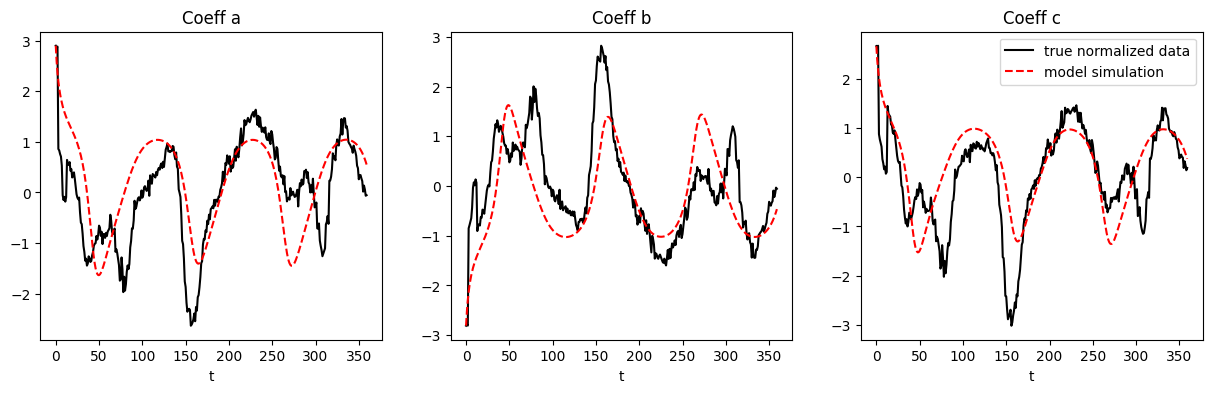

In [13]:
window_length=4
ensem_thresh = 0.12
ensem_alpha=1e-3
ensem_max_iter= 100 
degree = 3
num_models = 40
ens_time_window = 100

# seed = 3458
# seed = 12

# np.random.seed(seed)
_, model, X_train, X_train_sim, scalar = sindy_pipeline(time_series = mean_array,
                                                        window_length=window_length,
                                                        ensem_thresh = ensem_thresh,
                                                        ensem_alpha=ensem_alpha,
                                                        ensem_max_iter=ensem_max_iter, 
                                                        poly_degree =degree,
                                                        ensem_num_models = num_models,
                                                        # stabalzing_eps=stabalizing_eps,
                                                        ensem_time_points = ens_time_window)

## Check out master branch to fix ensemble optimizer
https://pysindy.readthedocs.io/en/latest/api/pysindy.optimizers.html#pysindy.optimizers.base.EnsembleOptimizer

https://github.com/dynamicslab/pysindy/blob/2633ee091d5648cd67bb061f5888e44adbf14a5c/pysindy/optimizers/base.py#L219


# Stabalizing SINDy

In [11]:
from utils import get_func_from_SINDy
from scipy.integrate import solve_ivp

# Get function in correct format to be evaluated 
funcs = get_func_from_SINDy(model=model)

# Define Right-hand side of ODE system 
a_dot = lambda a,b,c: eval(funcs[0])
b_dot = lambda a,b,c: eval(funcs[1])
c_dot = lambda a,b,c: eval(funcs[2])

# Get degree of feature library
poly_degree = model.feature_library.get_params()['degree']
stabalizing_degree = poly_degree+1


In [12]:
# Define new ODE system 
def ode_sys(t, y,
            a_dot=a_dot,
            b_dot=b_dot,
            c_dot=c_dot, 
            stabalizing_deg=stabalizing_degree,
            eps = 1e-5):
    a,b,c = y
    da = a_dot(a,b,c) - eps*a**stabalizing_deg
    db = b_dot(a,b,c) - eps*b**stabalizing_deg
    dc = c_dot(a,b,c) - eps*c**stabalizing_deg
    rhs = [da,db,dc]
    return rhs


From [SINDy docs](https://pysindy.readthedocs.io/en/latest/examples/1_feature_overview/example.html#A-note-on-solve_ivp-vs-odeint-before-we-continue) to replicate how `model.simulate()` functions

In [13]:
# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"
integrator_keywords["atol"] = 1e-12

### Solve ODE system

In [14]:
t_solve = np.array([i for i in range(len(mean_array))])

y0 = X_train[0]
eps=0

np.random.seed(seed)

params = (a_dot,b_dot,c_dot,stabalizing_degree,eps)

X_solved = solve_ivp(ode_sys,
                     t_span=(t_solve[0],t_solve[-1]),
                     y0=y0, 
                     t_eval=t_solve,
                     args=params,
                      **integrator_keywords)


### Plot the Results

(3, 494)
494


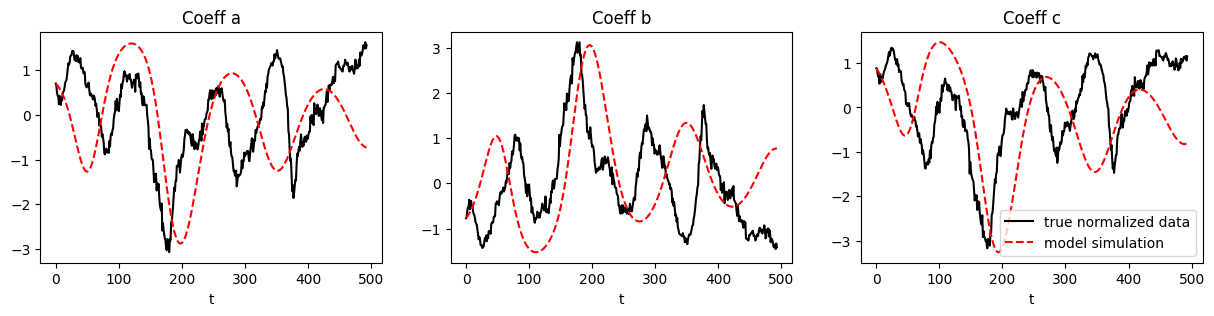

In [15]:
##################
## Plot Results ##
##################

X_stable_sim = X_solved.y
print(X_stable_sim.shape)

m = min(X_train.shape[0],X_stable_sim[0].shape[0])
print(m)

fig, axs = plt.subplots(1,X_train.shape[1], sharex=True, figsize=(15, 3))
# fig.suptitle("Learned Normalized Coefficients")  # Add this line to set the title

for i in range(X_train.shape[1]):
    if i == X_train.shape[1]-1:
        axs[i].plot(t_solve[:m], X_train[:m, i], "k", label="true normalized data")
        axs[i].plot(t_solve[:m], X_stable_sim.T[:m, i], "r--", label="model simulation")
        axs[i].legend(loc="best")
    else:
        axs[i].plot(t_solve[:m], X_train[:m, i], "k")
        axs[i].plot(t_solve[:m], X_stable_sim.T[:m, i], "r--")
    axs[i].set(xlabel="t")
    axs[i].set_title("Coeff {}".format(model.feature_names[i]))
fig.show()

### Check if results are the same as `model.simulate()`

Text(0.5, 1.0, 'Absolute Difference between method: eps=0')

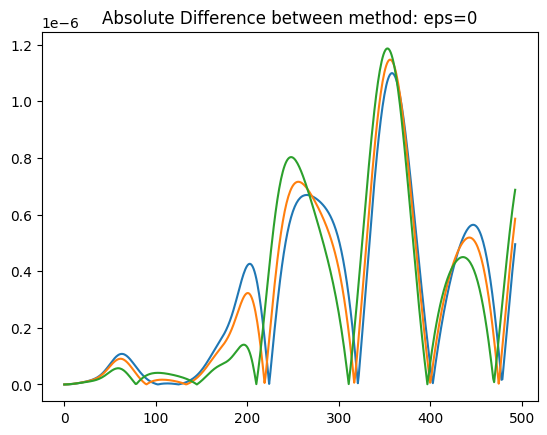

In [16]:
diff = np.abs(X_stable_sim-X_train_sim.T)
for i in range(3):
    plt.plot(diff[i])

plt.title(f"Absolute Difference between method: eps={eps}")


## Solve ODE example (Lorenz)

# FFT of data

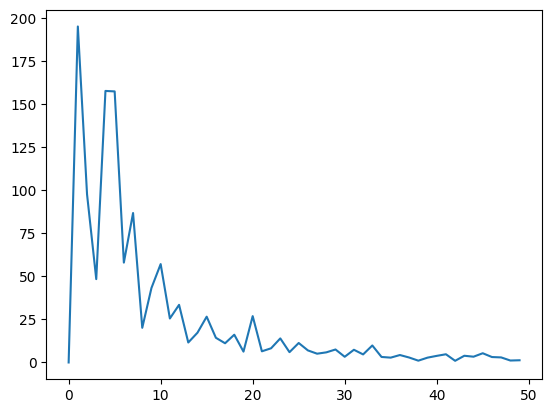

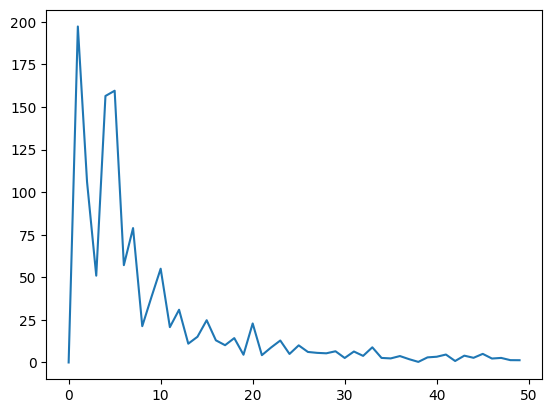

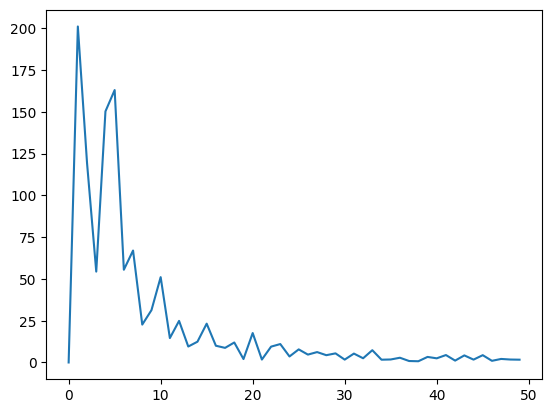

In [17]:
for i in range(3):
    plt.plot(np.abs(np.fft.rfft(X_train[:,i]-np.mean(X_train[:,i])))[:50])
    plt.show()

### plot normalized coefficients and learned derivatives

In [ ]:
# t = np.array([i for i in range(len(mean_array))])
# scalar = StandardScaler()
# normalized_mean_array = scalar.fit_transform(mean_array)

# thresh = 0.1
# feature_names = ['a', 'b', 'c']
# smoothed_fd = ps.SmoothedFiniteDifference(smoother_kws = {'window_length': 5})

# ensemble_optimizer = ps.STLSQ(threshold=thresh, alpha = 1e-3, max_iter=200)
# model = ps.SINDy(feature_names=feature_names,
#                 optimizer=ensemble_optimizer,
#                 differentiation_method=smoothed_fd)
# model.fit(normalized_mean_array,t=t, ensemble=True,quiet=True)
# model.print()

In [ ]:
# smoothed_fd = ps.SmoothedFiniteDifference(smoother_kws={'window_length': 8})

# x_dot = smoothed_fd._differentiate(normalized_mean_array, t)

# # Create a 2x2 grid of subplots
# fig, axs = plt.subplots(2, 2, figsize=(8, 5))

# # Plot the first set of data (a and a') in the first subplot
# axs[0, 0].plot(t, normalized_mean_array[:,0], label="a")
# axs[0, 0].plot(t, x_dot[:,0], label="a'")
# axs[0, 0].legend()

# # Plot the second set of data (b and b') in the second subplot
# axs[0, 1].plot(t, normalized_mean_array[:,1], label="b")
# axs[0, 1].plot(t, x_dot[:,1], label="b'")
# axs[0, 1].legend()

# # Plot the third set of data (c and c') in the third subplot
# axs[1, 0].plot(t, normalized_mean_array[:,2], label="c")
# axs[1, 0].plot(t, x_dot[:,2], label="c'")
# axs[1, 0].legend()

# # Hide the empty fourth subplot
# axs[1, 1].axis('off')

# fig.suptitle('Coefficients and Learned Derivatives', fontsize=16)

# # Adjust layout and display the subplot
# plt.tight_layout()
# plt.show()

In [ ]:
plume_learner.frame_height

In [ ]:
plume_learner.frame_width

In [ ]:
mean_array.shape